<a href="https://colab.research.google.com/github/Ash-0154/Leveraging-RFM-Analysis-for-Customer-Segmentation-and-Lifetime-Value-Prediction-in-Banking-Sector/blob/main/RFM_CLTV_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧠 Customer Lifetime Value (CLTV) Prediction - Overview

This notebook focuses on building a regression-based pipeline to predict **Customer Lifetime Value (CLTV)** using customer behavior data. The prediction enables banking and financial institutions to identify high-value customers and optimize marketing strategies accordingly.

## Dataset
Source: Kaggle - Credit Card Customer Dataset

Fields include: Avg_Credit_Limit, Total_Visits_Online, Total_Credit_Cards, Total_Calls_Made, etc.

Used for both CLTV prediction and segmentation

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Credit Card Customer Data.csv to Credit Card Customer Data.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


## 🧹 Data Cleaning & Preprocessing

Before performing any clustering, we start with cleaning and validating the dataset:

- **Missing Values**: Checked for null values in all columns.
- **Duplicates**: Verified if duplicate rows exist.
- **Data Types**: Ensured columns are in the correct format.
- **Outlier Handling**: IQR method was used to cap extreme values for:
  - `Avg_Credit_Limit`
  - `Total_visits_online`

In addition, the column `Total_visits_online` was coerced to integer format by:
- Converting strings to numerics
- Rounding off decimals

In [3]:

data = pd.read_csv('Credit Card Customer Data.csv')
#Data preprocessing
# Step 1: Check for Missing Values
print("Missing Values in the Dataset:")
print(data.isnull().sum())


# Step 2: Check for Duplicate Rows
duplicate_rows = data.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicate_rows}")


# Step 3: Check Data Types
print("\nData Types of Each Column:")
print(data.dtypes)

# Step 4: Check for Outliers in Numerical Columns
numerical_columns = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']

print("\nOutliers in Numerical Columns:")
for col in numerical_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")


def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

handle_outliers_iqr(data, 'Avg_Credit_Limit')
handle_outliers_iqr(data, 'Total_visits_online')
print("Outliers after handling:")
for col in ['Avg_Credit_Limit', 'Total_visits_online']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")
data.to_csv('Cleaned_Customer_Data.csv', index=False)

# Step 6: Summary Statistics
print("\nSummary Statistics of Numerical Columns:")
print(data[numerical_columns].describe())


Missing Values in the Dataset:
Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

Number of Duplicate Rows: 0

Data Types of Each Column:
Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

Outliers in Numerical Columns:
Avg_Credit_Limit: 39 outliers
Total_Credit_Cards: 0 outliers
Total_visits_bank: 0 outliers
Total_visits_online: 37 outliers
Total_calls_made: 0 outliers
Outliers after handling:
Avg_Credit_Limit: 0 outliers
Total_visits_online: 0 outliers

Summary Statistics of Numerical Columns:
       Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
count        660.000000          660.000000         660.000000   
mean       31666.666667            4.706061           2.403030

In [4]:
# Convert 'Total_visits_online' column to numeric, handling errors
data['Total_visits_online'] = pd.to_numeric(data['Total_visits_online'], errors='coerce')
# Check for non-integer values, using np.isfinite to handle NaNs
non_integer_values = data[~data['Total_visits_online'].apply(lambda x: np.isfinite(x) and float(x).is_integer())]
print("Rows with non-integer values in Total_visits_online:")
print(non_integer_values)
# Round non-integer values and convert to int
data['Total_visits_online'] = data['Total_visits_online'].round().astype(int)
print("\nUnique values in Total_visits_online after rounding:")
print(data['Total_visits_online'].unique())
data.to_csv('Cleaned_Customer_Data.csv', index=False)


Rows with non-integer values in Total_visits_online:
     Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
1        2         38414             50000                   3   
4        5         47437            100000                   6   
6        7         48370            100000                   5   
612    613         94391            105000                   9   
613    614         50598             94000                   9   
615    616         77910            105000                   9   
616    617         89832             96000                  10   
617    618         98216            105000                   8   
618    619         54495            105000                   7   
619    620         47650            105000                   7   
620    621         32107            105000                  10   
621    622         84192            105000                   9   
622    623         53916            105000                  10   
624    625         9728

## 🧮 RFM Feature Engineering

We computed Recency, Frequency, and Monetary metrics to represent customer behavior:

- **Recency (R)**: Inverse of `Total_calls_made` → More recent = higher score
- **Frequency (F)**: Sum of bank and online visits → Indicates engagement level
- **Monetary (M)**: Proxy via `Avg_Credit_Limit`

All RFM features were normalized using `MinMaxScaler` to a [1, 5] range to ensure fair clustering.

An overall **RFM Score** was created.This acts as a composite behavioral indicator.

In [5]:
# Step 1: Calculate Recency (R)
data['Recency'] = 1 / (data['Total_calls_made'] + 1)
# Step 2: Calculate Frequency (F)
data['Frequency'] = data['Total_visits_bank'] + data['Total_visits_online']
# Step 3: Calculate Monetary (M)
data['Monetary'] = data['Avg_Credit_Limit']
# Step 4: Normalize RFM Scores
scaler = MinMaxScaler(feature_range=(1, 5))
rfm_data = data[['Recency', 'Frequency', 'Monetary']]

rfm_normalized = scaler.fit_transform(rfm_data)

data['Recency'] = rfm_normalized[:, 0]
data['Frequency'] = rfm_normalized[:, 1]
data['Monetary'] = rfm_normalized[:, 2]
# Step 5: Calculate RFM Score
data['RFM_Score'] = data['Recency'] + data['Frequency'] + data['Monetary']
print("\nProcessed Data with RFM Scores:")
print(data.head())



Processed Data with RFM Scores:
   Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  Recency  \
0                  1                    1                 0     5.00   
1                  0                    8                 9     1.04   
2                  1                    3                 4     1.48   
3                  1                    1                 4     1.48   
4                  0                    8                 3     1.70   

   Frequency  Monetary  RFM_Score  
0        1.5  4.803922  11.303922  
1        4.5  2.843137   8.383137  
2        2.5  2.843137   6.823137  
3    

## 📊 Exploratory Data Analysis (EDA)

Visualizations performed include:

- **Histograms**: Distribution of each numeric variable.
- **Boxplots**: Outlier detection across RFM and visit features.
- **Heatmap**: Pearson correlation to observe linear dependencies.
- **RFM Segmentation**: Quartile-based labeling of customers as Low, Medium, High, Very High based on RFM Score.


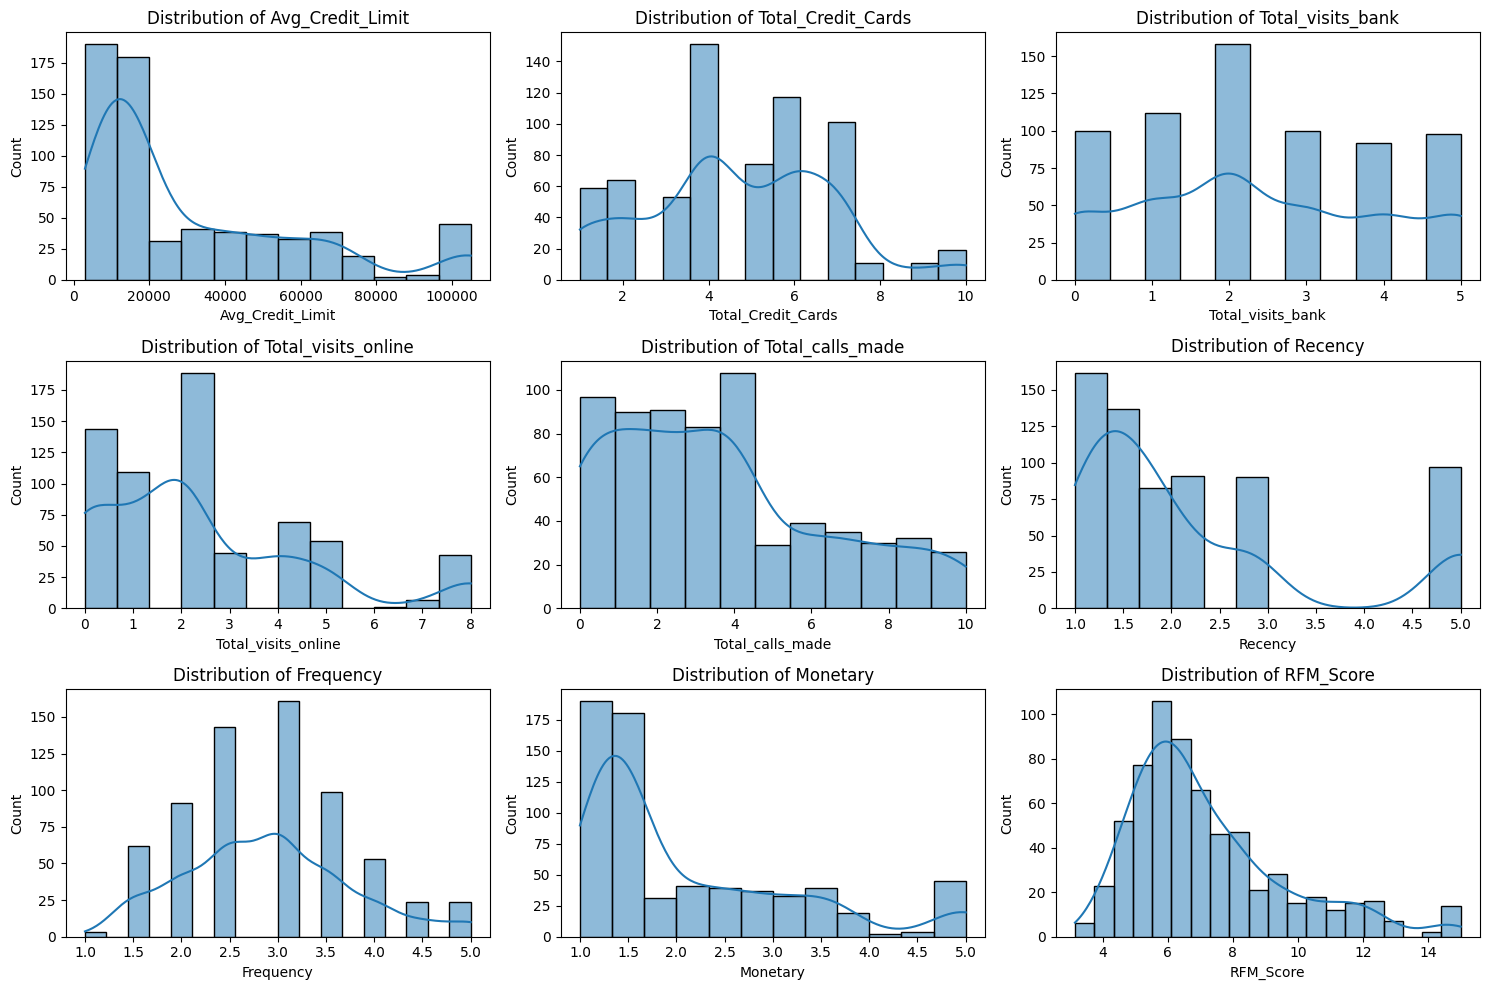

In [6]:
# Plot histograms for numerical features
numerical_columns = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

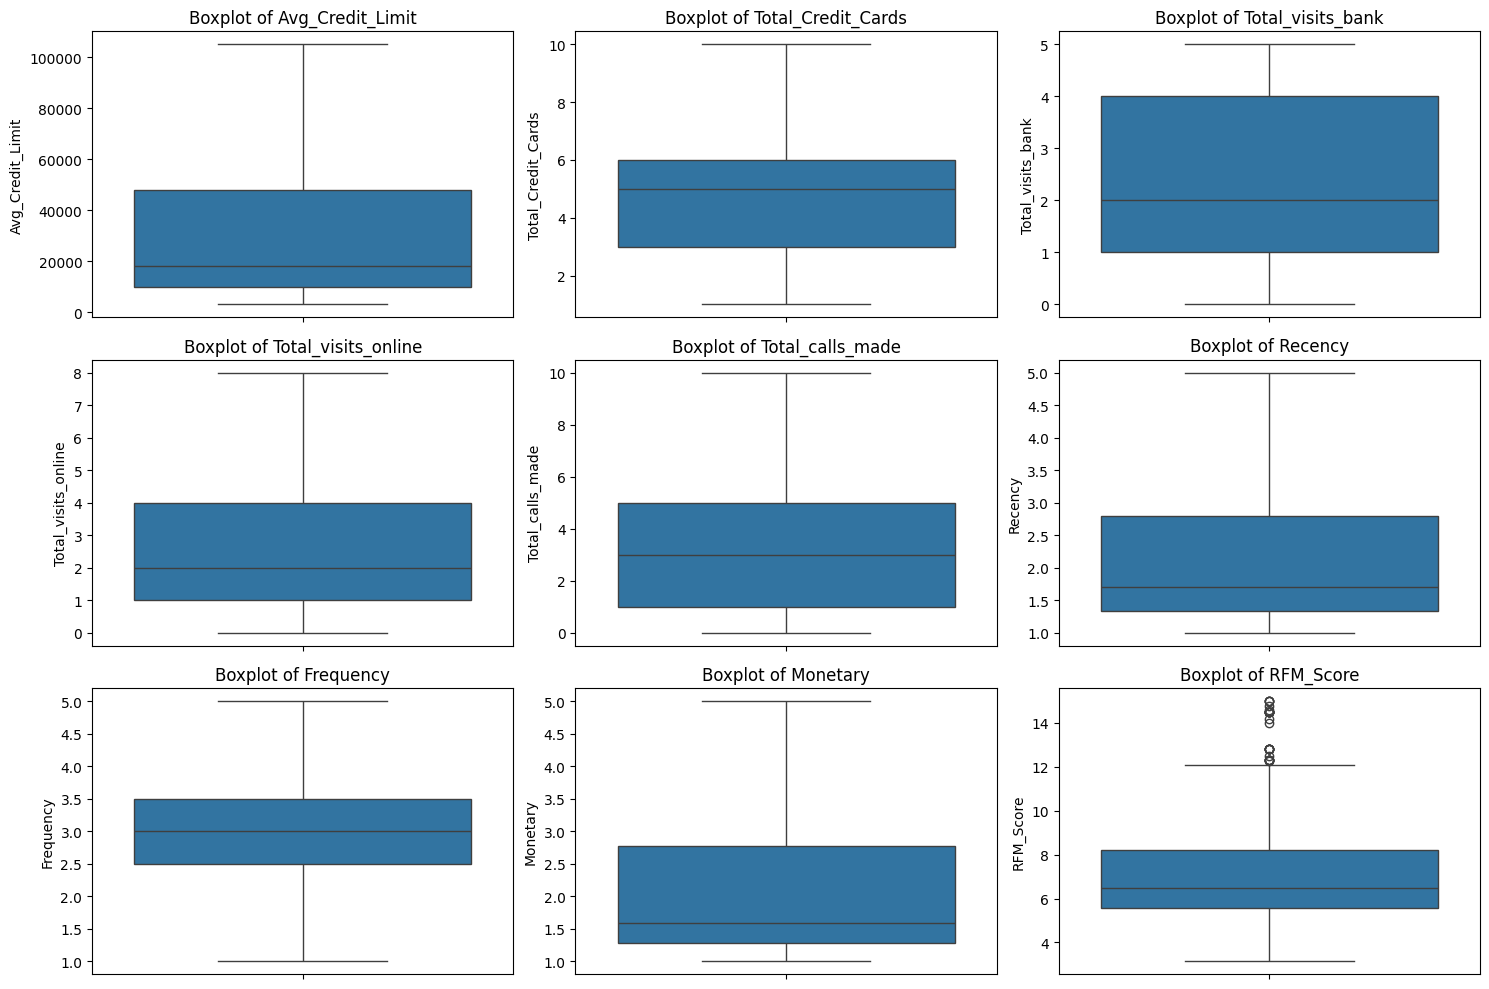

In [7]:
# Plot boxplots for numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

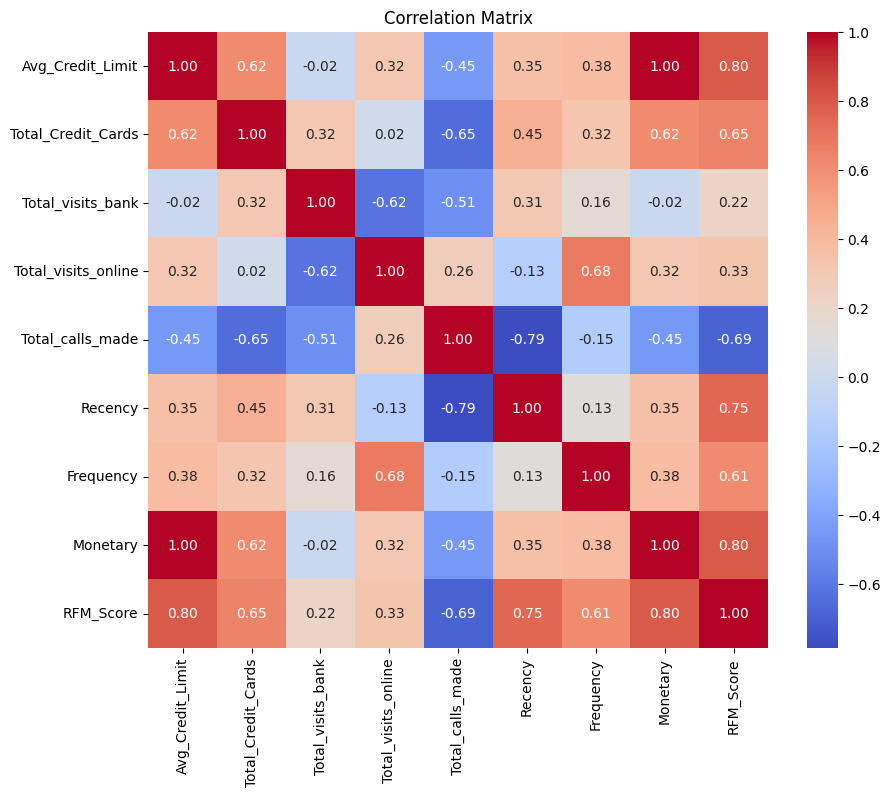

In [8]:
# Calculate correlation matrix
corr_matrix = data[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

/tmp/ipython-input-9-2328336599.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RFM_Segment', data=data, palette='viridis')


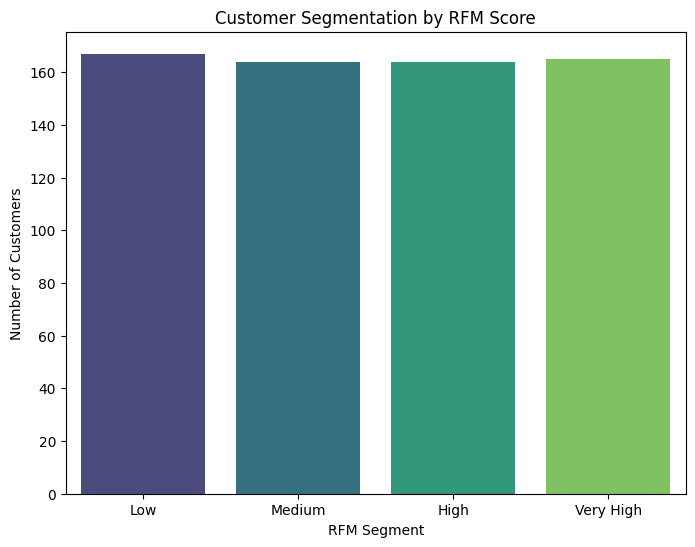

In [9]:
# Segment customers based on RFM Score
data['RFM_Segment'] = pd.qcut(data['RFM_Score'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Plot RFM segments
plt.figure(figsize=(8, 6))
sns.countplot(x='RFM_Segment', data=data, palette='viridis')
plt.title('Customer Segmentation by RFM Score')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.show()

## 🎯 Customer Lifetime Value (CLTV) Target Variable

Since true CLTV values are not available, we synthesize it as:  This is a proxy combining financial capacity (credit limit) and interaction frequency.



In [10]:
# Define features and target
features = ['Customer Key','Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']
target = 'CLTV'
# Create synthetic CLTV target
data['CLTV'] = data['Avg_Credit_Limit'] * (data['Total_visits_bank'] + data['Total_visits_online'])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

## 🤖 CLTV Prediction using XGBoost

We use `XGBRegressor` for initial CLTV prediction. Features include:

- RFM metrics
- Visit counts
- Credit card counts
- Customer key

Evaluation metrics:
- **MAE**: Mean Absolute Error
- **RMSE**: Root Mean Squared Error
- **R²**: Goodness of Fit

We also segment customers based on predicted CLTV: Low, Medium, High.


In [11]:
# Train initial XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Predictions
predictions_xgb = xgb_model.predict(X_test)
# Store predictions in a new dataframe
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Predicted_CLTV'] = predictions_xgb

# Segment customers based on CLTV
X_test_with_predictions['CLTV_Segment'] = pd.cut(X_test_with_predictions['Predicted_CLTV'],
                                                 bins=[0, 50000, 100000, float('inf')],
                                                 labels=['Low', 'Medium', 'High'])

# Display results
print(X_test_with_predictions[['Customer Key', 'Predicted_CLTV', 'CLTV_Segment']].head())


     Customer Key  Predicted_CLTV CLTV_Segment
629         76203   740493.187500         High
499         65825   411552.156250         High
135         45583    74269.171875       Medium
480         76024   102381.171875         High
90          18007    65103.570312       Medium


XGBoost Evaluation:
MAE: 3785.728271484375
MSE: 68125424.0
RMSE: 8253.812694749015
R-squared: 0.998651921749115


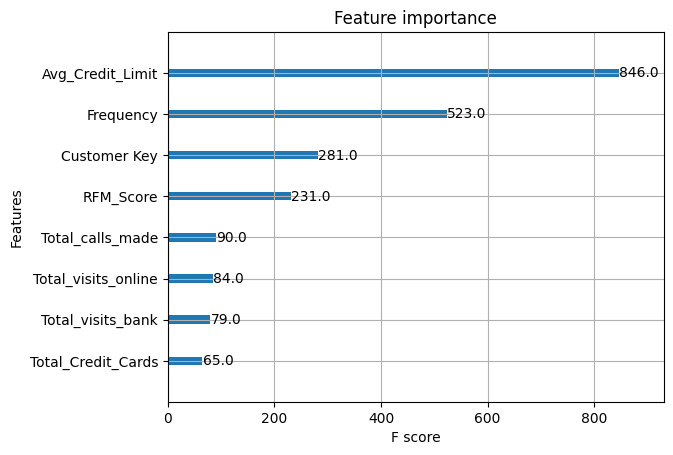

In [12]:
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
mse_xgb = mean_squared_error(y_test, predictions_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, predictions_xgb)

print("XGBoost Evaluation:")
print(f"MAE: {mae_xgb}")
print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"R-squared: {r2_xgb}")

# Feature Importance Plot
xgb.plot_importance(xgb_model)
plt.show()


## ⚙️ Hyperparameter Tuning for XGBoost

We tune learning rate, depth, and number of estimators using `GridSearchCV`.  
The best parameters are then used to retrain the model for improved accuracy.

Key improvement seen in:
- Reduced MAE
- Better generalization


In [13]:
from sklearn.model_selection import GridSearchCV, train_test_split
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5],
    'n_estimators': [200, 300, 500]
}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'),
                           param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=3)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


In [14]:
# Train with optimized parameters
xgb_best = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, objective='reg:squarederror')
xgb_best.fit(X_train, y_train)

# Predict with the optimized model
y_pred = xgb_best.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("XGBoost Evaluation after Hyperparameter Tuning:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")


XGBoost Evaluation after Hyperparameter Tuning:
MAE: 3733.88623046875
MSE: 67885800.0
RMSE: 8239.283949470366
R-squared: 0.9986566305160522


## 🔍 SHAP (Explainable AI)

We use SHAP to interpret model predictions:

- **Summary Plot**: Global feature importance
- **Dependence Plot**: Visualize how a specific feature affects predictions
- **Force & Waterfall Plot**: Local explanations for individual customers

Key Insight: Features like `RFM_Score` and `Avg_Credit_Limit` drive CLTV predictions.


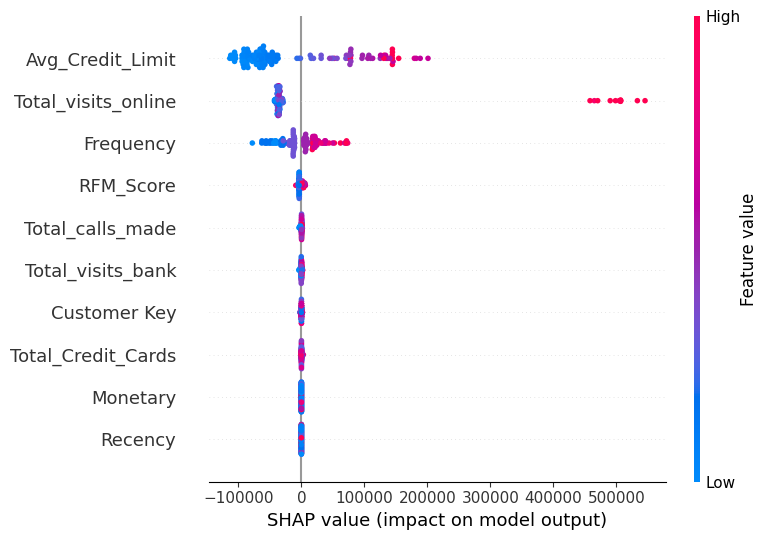

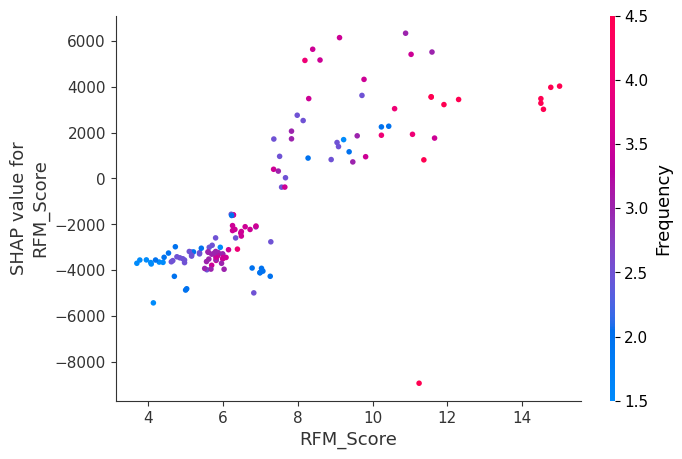

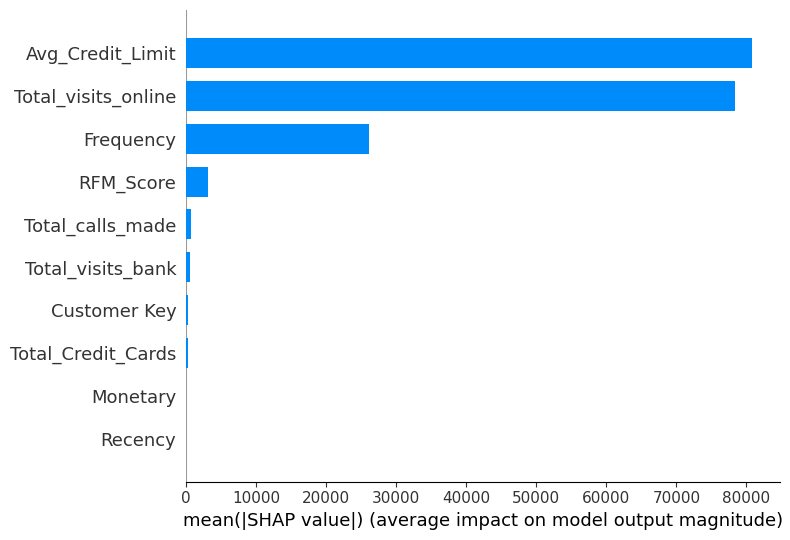

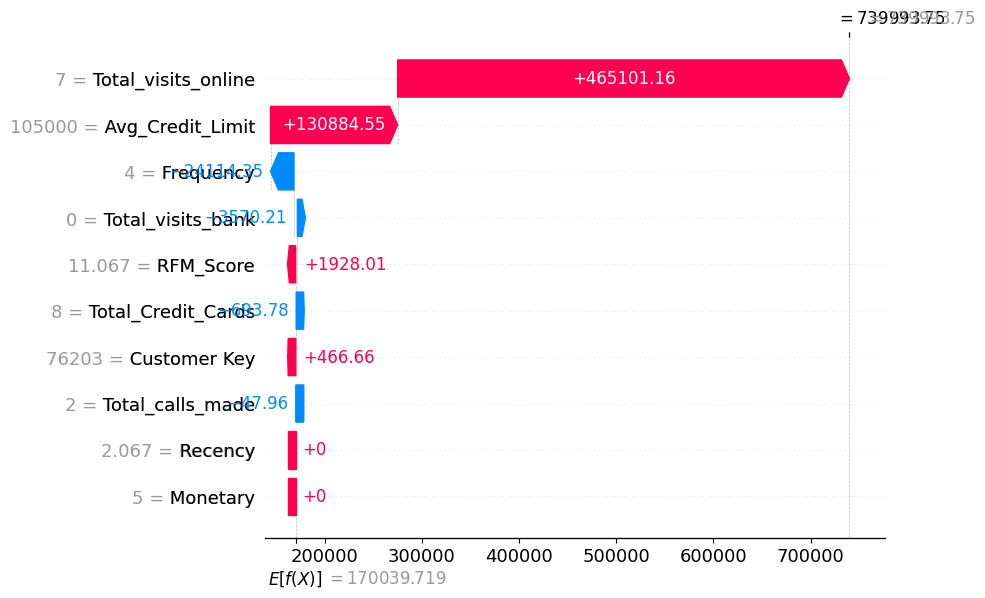

In [15]:
# Initialize SHAP explainer using the trained XGBoost model
explainer = shap.TreeExplainer(xgb_best)

# Compute SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot (Feature Importance)
shap.summary_plot(shap_values, X_test, feature_names=features)

# SHAP Dependence Plot for 'RFM_Score'
shap.dependence_plot("RFM_Score", shap_values, X_test, feature_names=features)

# SHAP Bar Plot (Global Feature Importance)
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="bar")

# SHAP Force Plot (For the first customer in test data)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], feature_names=features)

# SHAP Waterfall Plot (Explains prediction for the first test example)
shap.plots.waterfall(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test.iloc[0], feature_names=features))

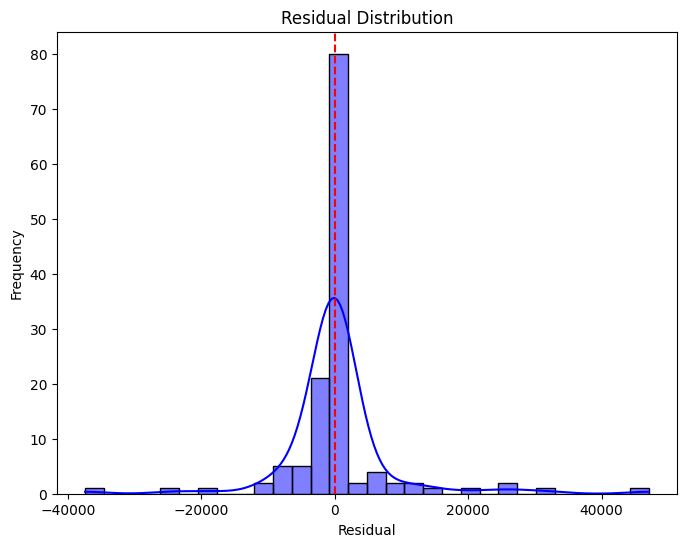

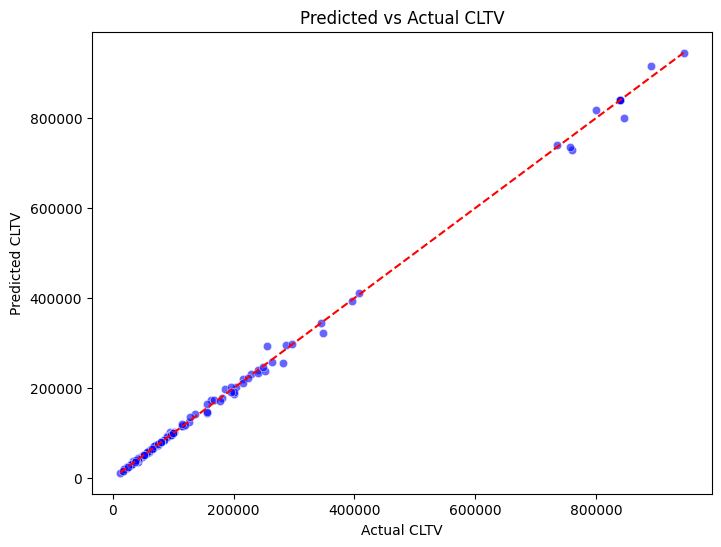

In [16]:
# Compute residuals
residuals = y_test - y_pred

# Residual distribution
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Predicted vs Actual CLTV
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal diagonal line
plt.xlabel("Actual CLTV")
plt.ylabel("Predicted CLTV")
plt.title("Predicted vs Actual CLTV")
plt.show()



In [17]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Place inside keyword arguments
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    learning_rate=0.05,
    max_depth=3,
    n_estimators=300
)


In [18]:
xgb_best = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, objective='reg:squarederror')

xgb_best.fit(X_train, y_train)

y_pred = xgb_best.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("XGBoost evaluation after hyperparameters:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")


XGBoost evaluation after hyperparameters:
MAE: 3733.88623046875
MSE: 67885800.0
RMSE: 8239.283949470366
R-squared: 0.9986566305160522


## 🌱 LightGBM for CLTV Prediction

LightGBM, a gradient boosting model optimized for speed and performance, is used.

Key Steps:
- Parameter tuning using early stopping
- Training & testing evaluations
- CLTV segmentation into High, Medium, Low

Visualization includes:
- SHAP plots for LightGBM
- Predicted vs Actual scatter plot
- Residual distribution


In [19]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.1, max_depth=5)
lgb_model.fit(X_train, y_train)

# Predict CLTV
predictions_lgb = lgb_model.predict(X_test)

# Evaluate
mae_lgb = mean_absolute_error(y_test, predictions_lgb)
mse_lgb = mean_squared_error(y_test, predictions_lgb)
r2_lgb = r2_score(y_test, predictions_lgb)
print("LightGBM evaluation:")
print(f"MAE: {mae_lgb}")
print(f"MSE: {mse_lgb}")
print(f"R²: {r2_lgb}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 528, number of used features: 10
[LightGBM] [Info] Start training from score 170039.772727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [20]:
# Predictions on train set
y_train_pred = lgb_model.predict(X_train)

# Train set evaluation
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print(f"Train Set Evaluation:")
print(f"MAE: {mae_train}")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"R²: {r2_train}")

Train Set Evaluation:
MAE: 2001.5498271541235
MSE: 10834809.143629795
RMSE: 3291.627127064941
R²: 0.9997749583005452


In [21]:
# Predictions on test set
y_test_pred = lgb_model.predict(X_test)

# Test set evaluation
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set Evaluation:")
print(f"MAE: {mae_test}")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")


Test Set Evaluation:
MAE: 4446.808502962878
MSE: 52754612.799338646
RMSE: 7263.237074427534
R²: 0.9989560631392317


In [22]:
from lightgbm import early_stopping
lgb_params = {
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 300,
    'num_leaves': 10,
    'lambda_l1': 5.0,
    'lambda_l2': 5.0,
    'min_child_samples': 50
}

lgb_model = lgb.LGBMRegressor(**lgb_params)
# Define the early stopping callback
early_stop_callback = early_stopping(stopping_rounds=50, verbose=True)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='l2',
    callbacks=[early_stop_callback]  # Pass the callback here
)

[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 528, number of used features: 10
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha

LGBMRegressor(lambda_l1=5.0, lambda_l2=5.0, learning_rate=0.05, max_depth=4,
              min_child_samples=50, n_estimators=300, num_leaves=10)

In [23]:
# Predict CLTV for training and testing sets
y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

# Create a DataFrame to store actual & predicted CLTV
train_results = pd.DataFrame({"Actual_CLTV": y_train, "Predicted_CLTV": y_train_pred})
test_results = pd.DataFrame({"Actual_CLTV": y_test, "Predicted_CLTV": y_test_pred})

# Define CLTV Segmentation thresholds
high_threshold = np.percentile(y_train_pred, 75)  # Top 25% customers
low_threshold = np.percentile(y_train_pred, 25)   # Bottom 25% customers

def segment_cltv(value):
    if value >= high_threshold:
        return "High Value"
    elif value <= low_threshold:
        return "Low Value"
    else:
        return "Medium Value"

# Assign CLTV Segments
train_results["CLTV_Segment"] = train_results["Predicted_CLTV"].apply(segment_cltv)
test_results["CLTV_Segment"] = test_results["Predicted_CLTV"].apply(segment_cltv)


[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


In [24]:
def evaluate_model(y_true, y_pred, dataset="Train"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset} Set Evaluation:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print("-" * 40)

# Evaluate Training & Testing performance
evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_test, y_test_pred, "Test")

Train Set Evaluation:
MAE: 17575.8481
MSE: 1016885593.3694
RMSE: 31888.6436
R²: 0.9789
----------------------------------------
Test Set Evaluation:
MAE: 20788.6980
MSE: 1335122959.3807
RMSE: 36539.3344
R²: 0.9736
----------------------------------------


In [25]:
# Predictions on test set
y_test_pred = lgb_model.predict(X_test)

# Test set evaluation
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set Evaluation:")
print(f"MAE: {mae_test}")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
Test Set Evaluation:
MAE: 20788.697960455098
MSE: 1335122959.3806686
RMSE: 36539.33441348746
R²: 0.9735798635039347


In [26]:
# Print Training Set Predictions & Segments
print("\nTrain Results (First 10 rows):")
print(train_results.head(10))

# Print Testing Set Predictions & Segments
print("\nTest Results (First 10 rows):")
print(test_results.head(10))



Train Results (First 10 rows):
     Actual_CLTV  Predicted_CLTV  CLTV_Segment
18         44000    45597.860930  Medium Value
363        12000     1516.266895     Low Value
597       266000   297676.970554    High Value
541       420000   448593.044280    High Value
61         72000    71889.209999  Medium Value
265        54000    55149.785566  Medium Value
346        57000    57865.499899  Medium Value
29         32000    27034.027889     Low Value
158        70000    89412.571379  Medium Value
584       170000   180768.172115  Medium Value

Test Results (First 10 rows):
     Actual_CLTV  Predicted_CLTV  CLTV_Segment
629       735000   870148.504661    High Value
499       408000   336121.348288    High Value
135        75000    64922.755893  Medium Value
480        94000    99969.513932  Medium Value
90         65000    48316.721938  Medium Value
456       287000   278029.866378    High Value
304        96000    70989.445550  Medium Value
235        52000    42700.494575     Low Val

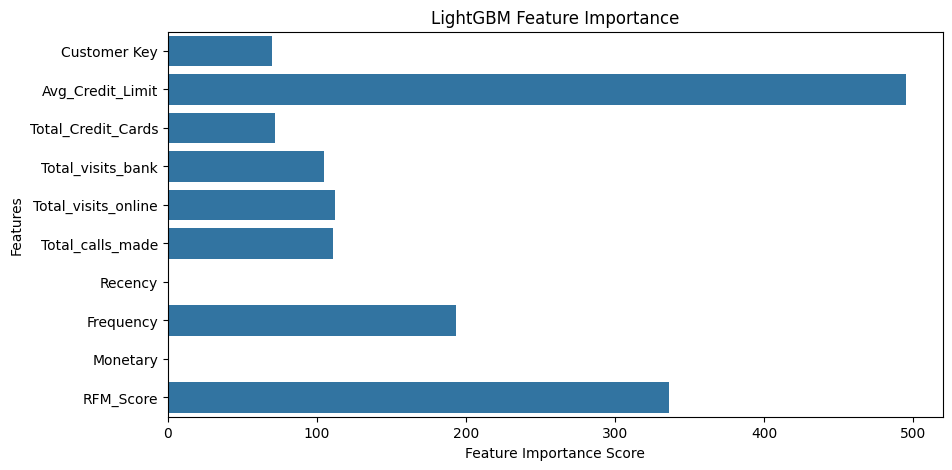

In [27]:
lgb_importance = lgb_model.feature_importances_

plt.figure(figsize=(10, 5))
sns.barplot(x=lgb_importance, y=X_train.columns)
plt.title("LightGBM Feature Importance")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

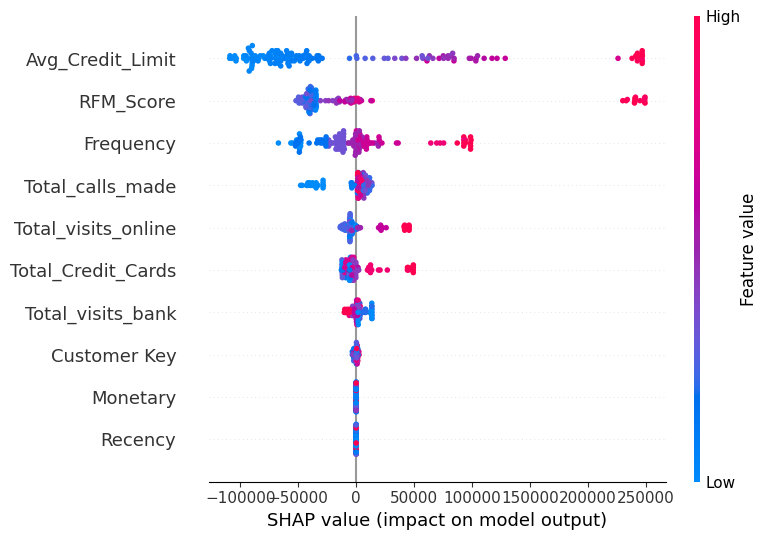

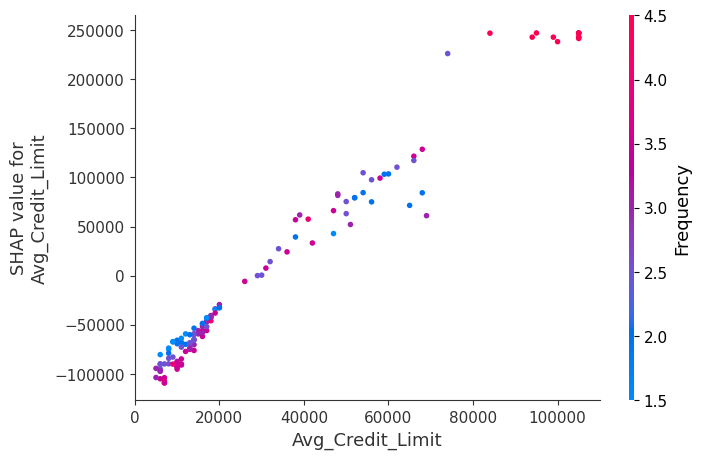

In [28]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(lgb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Convert SHAP values into a DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
shap_df["Predicted_CLTV"] = test_results["Predicted_CLTV"]
shap_df["CLTV_Segment"] = test_results["CLTV_Segment"]

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

# SHAP Dependence Plot (Example: Most Important Feature)
important_feature = X_train.columns[np.argmax(lgb_importance)]
shap.dependence_plot(important_feature, shap_values, X_test)

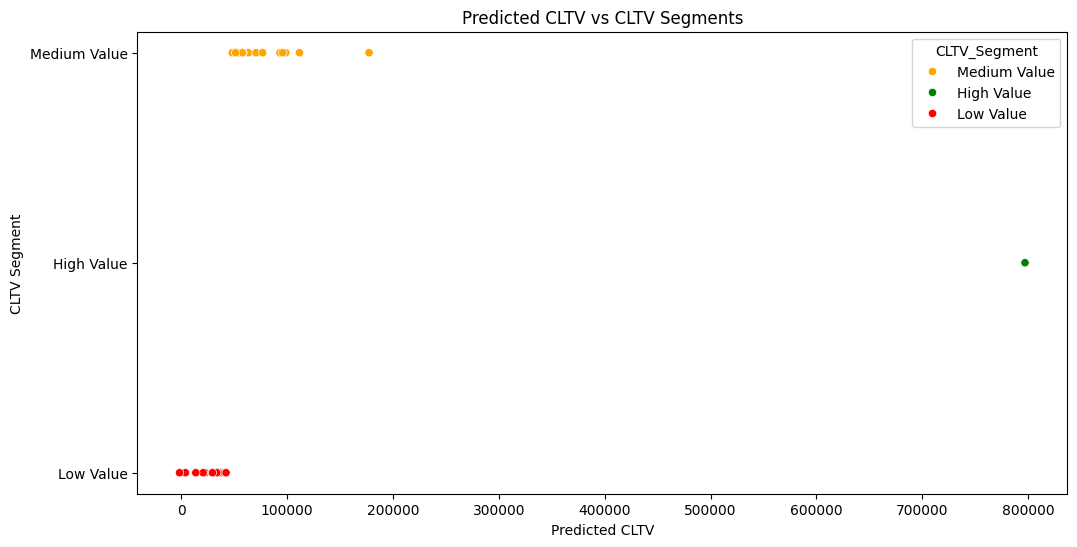

In [29]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=shap_df["Predicted_CLTV"], y=shap_df["CLTV_Segment"], hue=shap_df["CLTV_Segment"],
                palette={"Low Value": "red", "Medium Value": "orange", "High Value": "green"})
plt.xlabel("Predicted CLTV")
plt.ylabel("CLTV Segment")
plt.title("Predicted CLTV vs CLTV Segments")
plt.show()

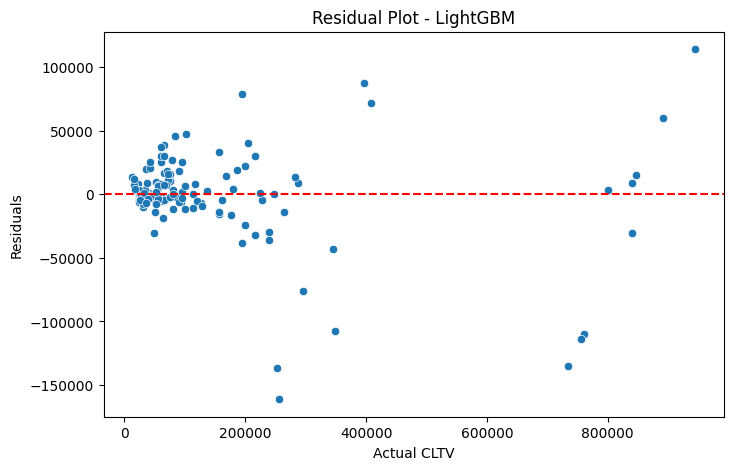

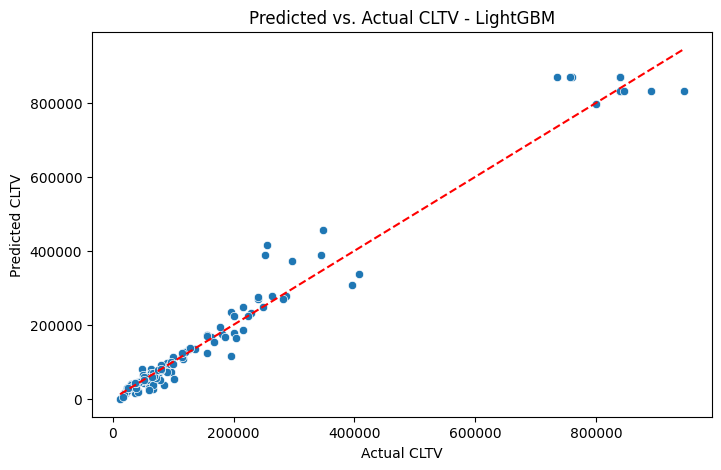

In [30]:
residuals = y_test - y_test_pred

# Residual Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual CLTV")
plt.ylabel("Residuals")
plt.title("Residual Plot - LightGBM")
plt.show()

# Predicted vs. Actual CLTV Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual CLTV")
plt.ylabel("Predicted CLTV")
plt.title("Predicted vs. Actual CLTV - LightGBM")
plt.show()

## 🌳 Extra Trees Regressor for CLTV

An ensemble method based on randomized decision trees.

Steps:
- Model fitting with 500 estimators
- Feature importance bar plot
- SHAP summary and dependence plots
- Evaluation metrics and residual analysis

Works well on non-linear interactions and is fast to train.


In [31]:
from sklearn.ensemble import ExtraTreesRegressor
# Train Extra Trees Regressor
etr_model = ExtraTreesRegressor(n_estimators=500, max_depth=6, min_samples_split=5, random_state=42)
etr_model.fit(X_train, y_train)

# Predict CLTV for training and testing sets
y_train_pred = etr_model.predict(X_train)
y_test_pred = etr_model.predict(X_test)

# Create DataFrame with CustomerKey, Actual CLTV, and Predicted CLTV
train_results_etr = pd.DataFrame({
    "CustomerKey": X_train.index,  # Assuming CustomerKey is the index
    "Actual_CLTV": y_train,
    "Predicted_CLTV": y_train_pred
})

test_results_etr = pd.DataFrame({
    "CustomerKey": X_test.index,  # Assuming CustomerKey is the index
    "Actual_CLTV": y_test,
    "Predicted_CLTV": y_test_pred
})

# Define CLTV Segmentation thresholds
high_threshold = np.percentile(y_train_pred, 75)  # Top 25% customers
low_threshold = np.percentile(y_train_pred, 25)   # Bottom 25% customers

def segment_cltv(value):
    if value >= high_threshold:
        return "High Value"
    elif value <= low_threshold:
        return "Low Value"
    else:
        return "Medium Value"

# Assign CLTV Segments
train_results_etr["CLTV_Segment"] = train_results_etr["Predicted_CLTV"].apply(segment_cltv)
test_results_etr["CLTV_Segment"] = test_results_etr["Predicted_CLTV"].apply(segment_cltv)


print("\nTrain Results (First 10 rows - ETR):")
print(train_results_etr.head(10))

print("\nTest Results (First 10 rows - ETR):")
print(test_results_etr.head(10))



Train Results (First 10 rows - ETR):
     CustomerKey  Actual_CLTV  Predicted_CLTV  CLTV_Segment
18            18        44000    46879.840007  Medium Value
363          363        12000    19194.586140     Low Value
597          597       266000   254009.885519    High Value
541          541       420000   398904.804610    High Value
61            61        72000    71337.965463  Medium Value
265          265        54000    51916.622168  Medium Value
346          346        57000    64046.334836  Medium Value
29            29        32000    35356.345155     Low Value
158          158        70000    59377.302653  Medium Value
584          584       170000   173975.954137  Medium Value

Test Results (First 10 rows - ETR):
     CustomerKey  Actual_CLTV  Predicted_CLTV  CLTV_Segment
629          629       735000   703700.980392    High Value
499          499       408000   382657.604663    High Value
135          135        75000    74608.123606  Medium Value
480          480        9

In [32]:

# Evaluate Extra Trees Regressor
mae_etr = mean_absolute_error(y_test, y_test_pred)
mse_etr = mean_squared_error(y_test, y_test_pred)
rmse_etr = np.sqrt(mse_etr)
r2_etr = r2_score(y_test, y_test_pred)

print("Extra Trees Regressor Evaluation:")
print(f"MAE: {mae_etr}")
print(f"MSE: {mse_etr}")
print(f"RMSE: {rmse_etr}")
print(f"R-squared: {r2_etr}")



Extra Trees Regressor Evaluation:
MAE: 6964.225749050032
MSE: 93651402.45066926
RMSE: 9677.365470553917
R-squared: 0.9981467753075399


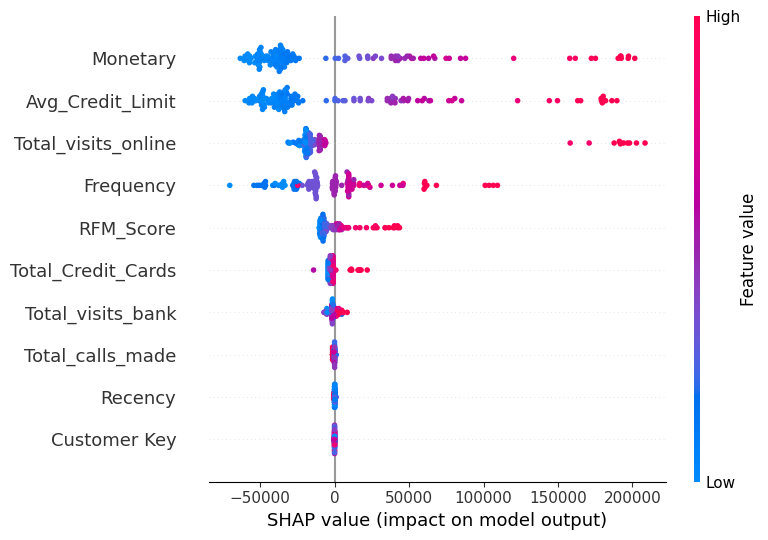

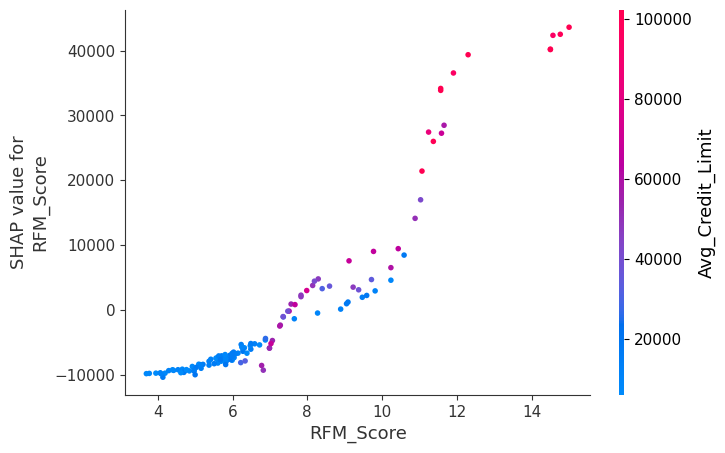

In [33]:


# Initialize SHAP explainer for ExtraTreesRegressor
explainer = shap.TreeExplainer(etr_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=features)

# SHAP Dependence Plot (Example: 'RFM_Score')
shap.dependence_plot("RFM_Score", shap_values, X_test, feature_names=features)




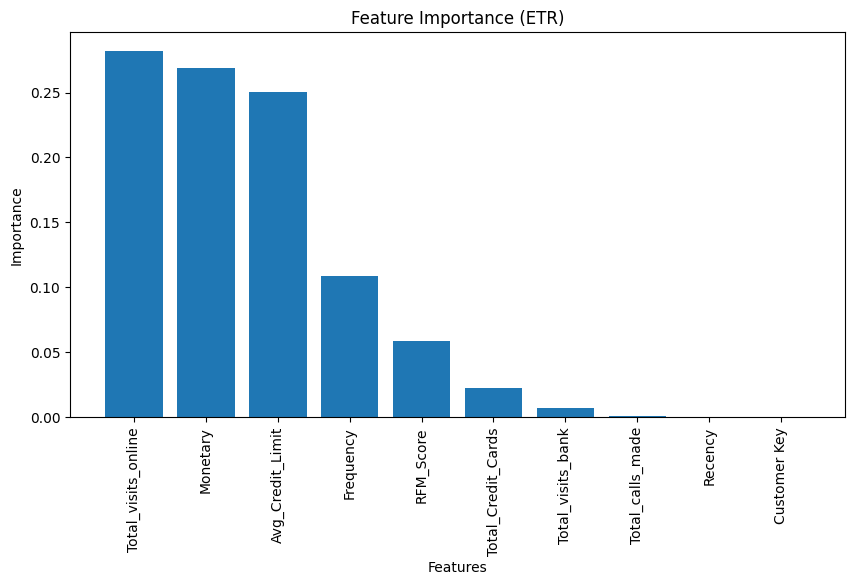

In [34]:
feature_importances = etr_model.feature_importances_
features = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(features)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(features)), np.array(features)[sorted_indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (ETR)")
plt.show()


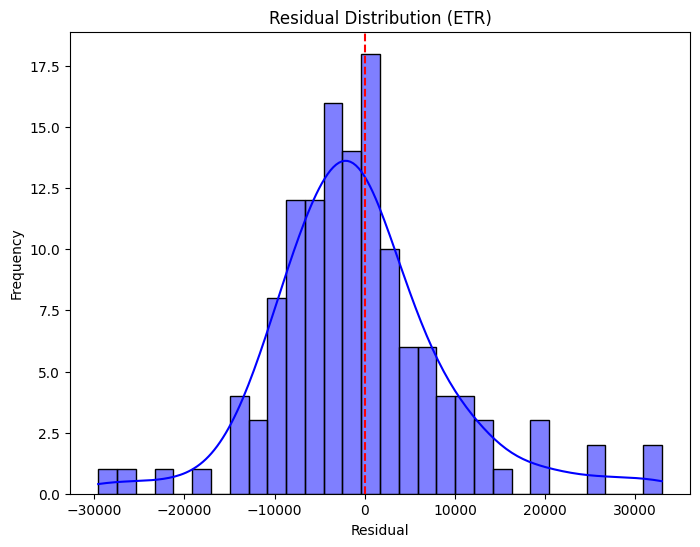

In [35]:
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.axvline(x=0, color='red', linestyle='dashed')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residual Distribution (ETR)")
plt.show()

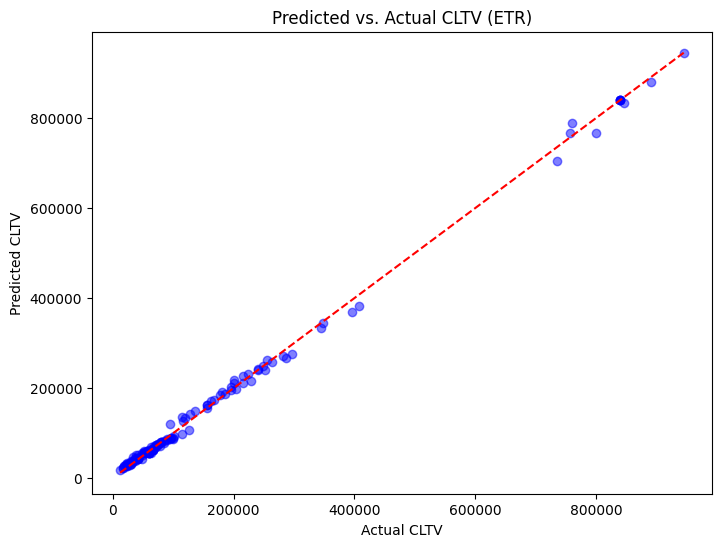

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.xlabel("Actual CLTV")
plt.ylabel("Predicted CLTV")
plt.title("Predicted vs. Actual CLTV (ETR)")
plt.show()


## 📊 HistGradientBoosting Regressor (HGBR)

Used for its speed and scalability, HGBR fits histograms instead of individual data points.

Steps:
- Train and test predictions
- Evaluation (MAE, MSE, RMSE, R²)
- Feature permutation importance
- Residuals and prediction plots
- CLTV segmentation into High, Medium, Low using percentiles


In [37]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

hgbr = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.05, random_state=42)
hgbr.fit(X_train, y_train)

y_train_pred = hgbr.predict(X_train)
y_test_pred = hgbr.predict(X_test)

print("HistGradientBoostingRegressor Evaluation:")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))  # Added MSE
print("Test MSE:", mean_squared_error(y_test, y_test_pred))    # Added MSE
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))  # Added RMSE
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))    # Added RMSE
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))


HistGradientBoostingRegressor Evaluation:
Train MAE: 3330.5418524726615
Test MAE: 5657.607157112705
Train MSE: 70253758.88459858
Test MSE: 131959097.37930538
Train RMSE: 8381.751540376186
Test RMSE: 11487.345097075537
Train R²: 0.9985408118331487
Test R²: 0.9973887218850045


In [38]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [None, 3, 5, 10],
    'min_samples_leaf': [5, 10, 20]
}

grid_search = GridSearchCV(HistGradientBoostingRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_hgbr = grid_search.best_estimator_

# Predict with best model
y_test_best_pred = best_hgbr.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [40]:
train_results_hgbr = pd.DataFrame({
    "CustomerKey": X_train.index,
    "Actual_CLTV": y_train,
    "Predicted_CLTV": y_train_pred
})

test_results_hgbr = pd.DataFrame({
    "CustomerKey": X_test.index,
    "Actual_CLTV": y_test,
    "Predicted_CLTV": y_test_pred
})

# Define CLTV Segmentation
high_threshold = np.percentile(y_train_pred, 75)
low_threshold = np.percentile(y_train_pred, 25)

def segment_cltv(value):
    if value >= high_threshold:
        return "High Value"
    elif value <= low_threshold:
        return "Low Value"
    else:
        return "Medium Value"

train_results_hgbr["CLTV_Segment"] = train_results_hgbr["Predicted_CLTV"].apply(segment_cltv)
test_results_hgbr["CLTV_Segment"] = test_results_hgbr["Predicted_CLTV"].apply(segment_cltv)

print("\nTrain Results (First 10 rows - HGBR):")
print(train_results_hgbr.head(10))

print("\nTest Results (First 10 rows - HGBR):")
print(test_results_hgbr.head(10))



Train Results (First 10 rows - HGBR):
     CustomerKey  Actual_CLTV  Predicted_CLTV  CLTV_Segment
18            18        44000    43157.884322     Low Value
363          363        12000    13603.693877     Low Value
597          597       266000   268704.417794    High Value
541          541       420000   421061.811333    High Value
61            61        72000    71533.015733  Medium Value
265          265        54000    53448.294617  Medium Value
346          346        57000    55942.738684  Medium Value
29            29        32000    29352.305199     Low Value
158          158        70000    65546.108892  Medium Value
584          584       170000   171343.684028  Medium Value

Test Results (First 10 rows - HGBR):
     CustomerKey  Actual_CLTV  Predicted_CLTV  CLTV_Segment
629          629       735000   816939.760111    High Value
499          499       408000   420905.130884    High Value
135          135        75000    74788.903701  Medium Value
480          480       

In [41]:
print("HistGradientBoostingRegressor Evaluation:")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))  # Added MSE
print("Test MSE:", mean_squared_error(y_test, y_test_pred))    # Added MSE
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))  # Added RMSE
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))    # Added RMSE
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

HistGradientBoostingRegressor Evaluation:
Train MAE: 3330.5418524726615
Test MAE: 5657.607157112705
Train MSE: 70253758.88459858
Test MSE: 131959097.37930538
Train RMSE: 8381.751540376186
Test RMSE: 11487.345097075537
Train R²: 0.9985408118331487
Test R²: 0.9973887218850045


/tmp/ipython-input-42-1291660395.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=features_df, palette="viridis")


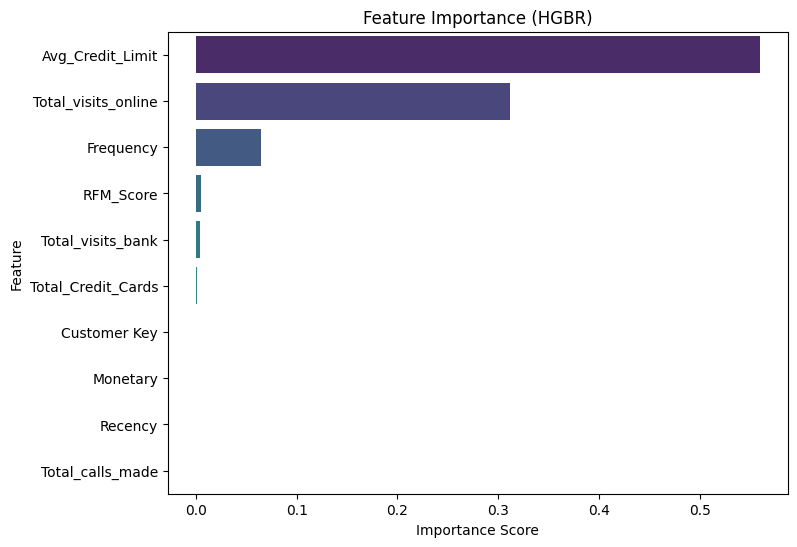

In [42]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(best_hgbr, X_test, y_test, n_repeats=10, random_state=42)

# Get feature importance scores
feature_importance = result.importances_mean

# Create a DataFrame
features_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})

# Sort by importance
features_df = features_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=features_df, palette="viridis")

# Labels and title
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance (HGBR)")
plt.show()

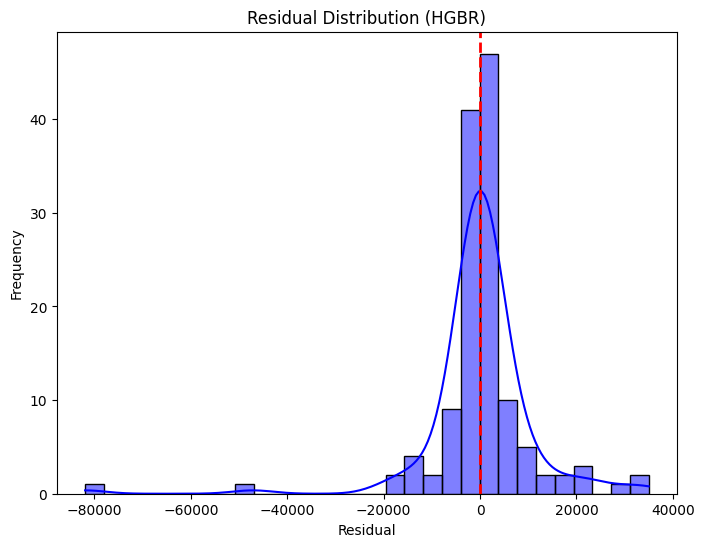

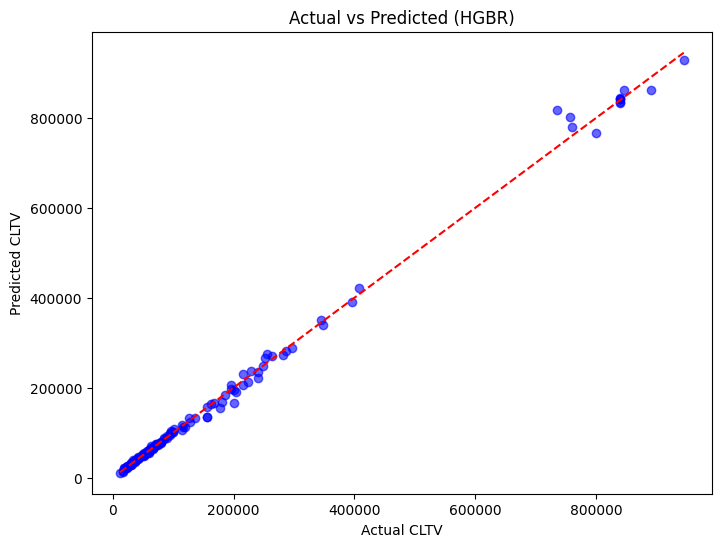

In [43]:
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue', edgecolor='black')
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residual Distribution (HGBR)")
plt.show()

# Predicted vs. Actual CLTV Plot

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color="blue", alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed")
plt.xlabel("Actual CLTV")
plt.ylabel("Predicted CLTV")
plt.title("Actual vs Predicted (HGBR)")
plt.show()

## 🧠 Ridge & Lasso Regression

Ridge and Lasso provide linear baselines with L2 and L1 regularization respectively.

- Predictions visualized using actual vs predicted plots
- CLTV segments created from predicted values
- Performance evaluated using MAE, RMSE, and R²

These serve as benchmark models.


In [45]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

# Predict CLTV
y_test_ridge_pred = ridge.predict(X_test)

ridge_results = pd.DataFrame({
    "CustomerKey": X_test.index,
    "Actual CLTV": y_test.values,
    "Predicted CLTV (Ridge)": y_test_ridge_pred
})

# Assign CLTV Segments
ridge_results["CLTV Segment"] = pd.qcut(ridge_results["Predicted CLTV (Ridge)"], q=4, labels=["Low", "Medium", "High", "Very High"])

# Print the first few rows
print("\nRidge Regression - CLTV Predictions:")
print(ridge_results.head())



y_pred_ridge = ridge.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_ridge)
mse = mean_squared_error(y_test, y_pred_ridge)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred_ridge)
medae = median_absolute_error(y_test, y_pred_ridge) # Median Absolute Error

# Print the metrics
print("Ridge Regression Evaluation Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")


Ridge Regression - CLTV Predictions:
   CustomerKey  Actual CLTV  Predicted CLTV (Ridge) CLTV Segment
0          629       735000           767124.297818    Very High
1          499       408000           391316.052383    Very High
2          135        75000            76592.228775       Medium
3          480        94000           152610.958382         High
4           90        65000            81357.940890       Medium
Ridge Regression Evaluation Metrics:
MAE: 35757.19775537125
MSE: 1919272335.1307201
RMSE: 43809.50051222589
R-squared: 0.962020399161739


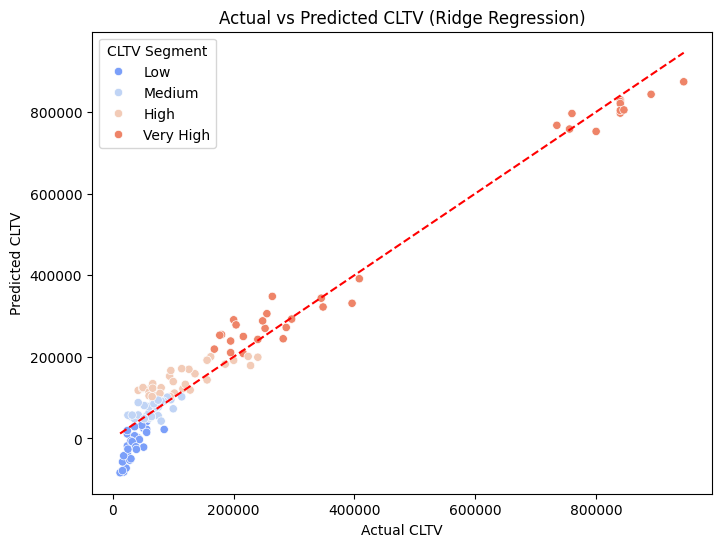

In [46]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ridge_results, x="Actual CLTV", y="Predicted CLTV (Ridge)", hue="CLTV Segment", palette="coolwarm")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed")
plt.xlabel("Actual CLTV")
plt.ylabel("Predicted CLTV")
plt.title("Actual vs Predicted CLTV (Ridge Regression)")
plt.show()


In [47]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Predict CLTV
y_test_lasso_pred = lasso.predict(X_test)

lasso_results = pd.DataFrame({
    "CustomerKey": X_test.index,  # Assuming CustomerKey is the index
    "Actual CLTV": y_test.values,
    "Predicted CLTV (Lasso)": y_test_lasso_pred
})

# Assign CLTV Segments
lasso_results["CLTV Segment"] = pd.qcut(lasso_results["Predicted CLTV (Lasso)"], q=4, labels=["Low", "Medium", "High", "Very High"])

# Print the first few rows
print("\nLasso Regression - CLTV Predictions:")
print(lasso_results.head())

# Evaluate Lasso Regression with all metrics
y_pred_lasso = lasso.predict(X_test)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)  # Root Mean Squared Error
r2_lasso = r2_score(y_test, y_pred_lasso)
medae_lasso = median_absolute_error(y_test, y_pred_lasso)  # Median Absolute Error


print("\nLasso Regression Evaluation Metrics:")
print(f"MAE: {mae_lasso}")
print(f"MSE: {mse_lasso}")
print(f"RMSE: {rmse_lasso}")
print(f"R-squared: {r2_lasso}")



Lasso Regression - CLTV Predictions:
   CustomerKey  Actual CLTV  Predicted CLTV (Lasso) CLTV Segment
0          629       735000           767705.669781    Very High
1          499       408000           391528.512769    Very High
2          135        75000            76759.024355       Medium
3          480        94000           151278.058924         High
4           90        65000            81582.363619       Medium

Lasso Regression Evaluation Metrics:
MAE: 35847.81576892741
MSE: 1928759313.8160424
RMSE: 43917.6423981985
R-squared: 0.9618326656874245


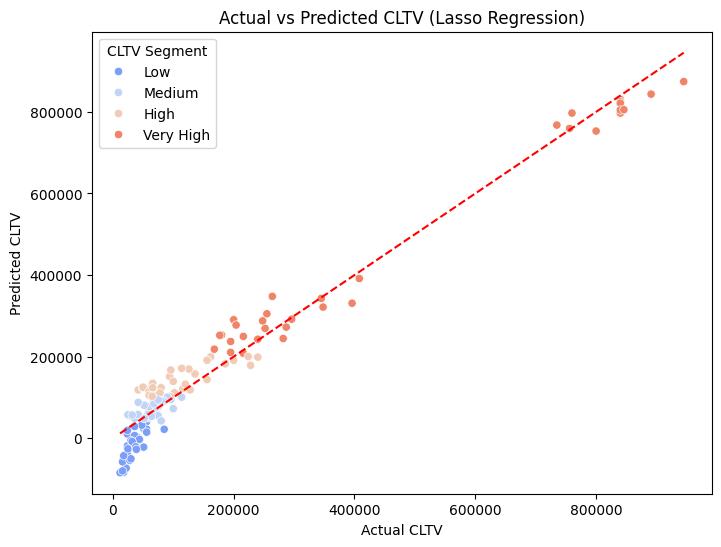

In [48]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=lasso_results, x="Actual CLTV", y="Predicted CLTV (Lasso)", hue="CLTV Segment", palette="coolwarm")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed")
plt.xlabel("Actual CLTV")
plt.ylabel("Predicted CLTV")
plt.title("Actual vs Predicted CLTV (Lasso Regression)")
plt.show()

## 🔁 NGBoost for CLTV

A probabilistic model that returns a distribution over predictions.

Steps:
- Fitted using DecisionTree base learner
- CLTV segmentation into quartiles
- Residual and predicted vs actual plots
- Performance metrics include MAE, MSE, RMSE, R²

Feature importance plotting is limited, as NGBoost doesn't always expose them.


In [49]:
!pip install ngboost
from ngboost import NGBRegressor
from sklearn.tree import DecisionTreeRegressor

ngb_model = NGBRegressor(Base=DecisionTreeRegressor(max_depth=4), learning_rate=0.1, n_estimators=500)
ngb_model.fit(X_train, y_train)

# Predict CLTV
y_test_ngb_pred = ngb_model.predict(X_test)

ngb_results = pd.DataFrame({
    "CustomerKey": X_test.index,  # Assuming CustomerKey is the index
    "Actual CLTV": y_test.values,
    "Predicted CLTV (NGBoost)": y_test_ngb_pred
})

# Assign CLTV Segments
ngb_results["CLTV Segment"] = pd.qcut(ngb_results["Predicted CLTV (NGBoost)"], q=4, labels=["Low", "Medium", "High", "Very High"])

# Print first few rows
print("\nNGBoost - CLTV Predictions:")
print(ngb_results.head())

# Evaluation
mae = mean_absolute_error(y_test, y_test_ngb_pred)
mse = mean_squared_error(y_test, y_test_ngb_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_test_ngb_pred)

print("NGBoost Evaluation Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 11.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=c41db8271e234c5c98cc3b08c57c3a2fd4131c2aeef55b80d24cebd35c687f7d
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
[iter 0] loss=13.7177 val_loss=0.0000 scale=1.0000 norm=144583.4625
[iter 100] loss=8.0619 val_loss=0.0000 scale=1.0000 norm=809.3174
[iter 200] loss=7.4855 val_loss=0.0000 scale=1.0000 norm=508.6115
[iter 300] loss=7.2535 val_loss=0.0000 scale=0.0000 norm=0.0008
[iter 400] loss=7.2535 val_loss=0.0000 scale=0.0000 norm=0.0008

NGBoost - CLTV Predictions:
   CustomerKey  Actual CLTV  Predicted CLTV (NGBoost) CLTV Segment
0          629       735000             738969.127188    Very High
1

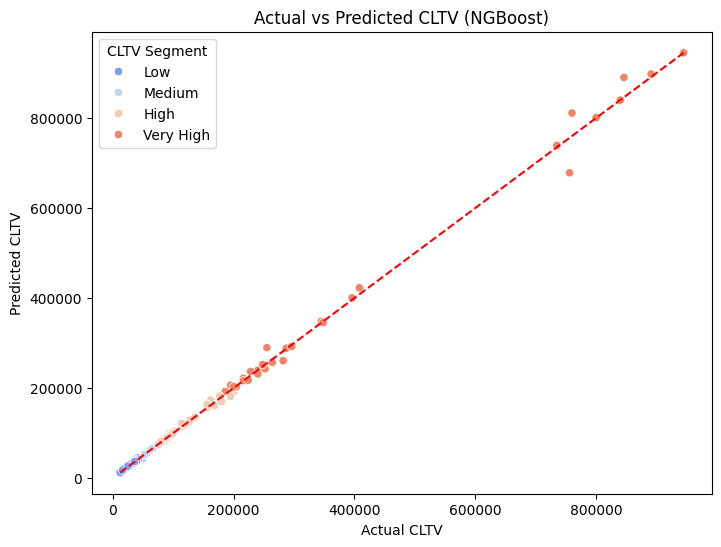

In [50]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ngb_results, x="Actual CLTV", y="Predicted CLTV (NGBoost)", hue="CLTV Segment", palette="coolwarm")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed")
plt.xlabel("Actual CLTV")
plt.ylabel("Predicted CLTV")
plt.title("Actual vs Predicted CLTV (NGBoost)")
plt.show()

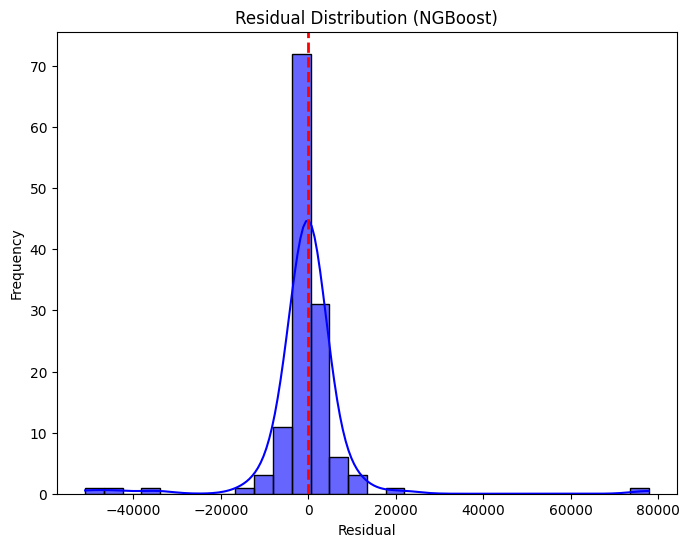

In [51]:
residuals = y_test - y_test_ngb_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residual Distribution (NGBoost)")
plt.show()


/tmp/ipython-input-53-4068717115.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="viridis")


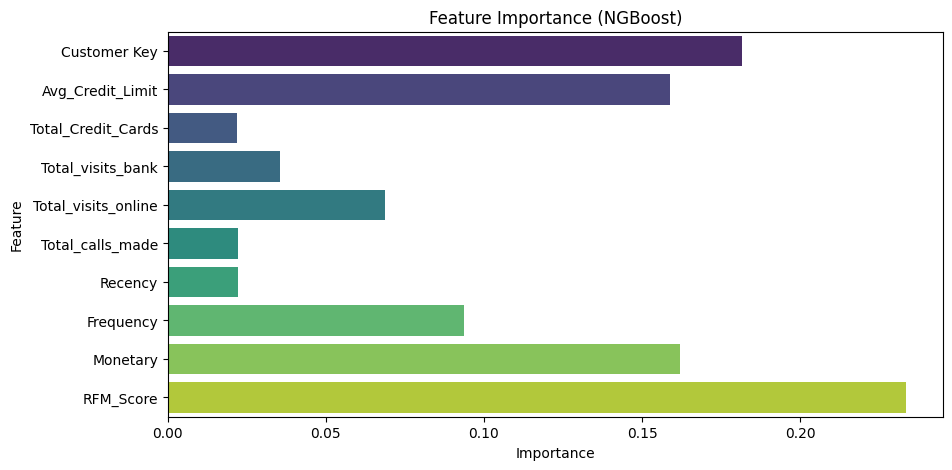

In [53]:
if hasattr(ngb_model, "feature_importances_"):
    importances = ngb_model.feature_importances_[0]
    features = X_train.columns if hasattr(X_train, "columns") else np.arange(len(importances))

    plt.figure(figsize=(10, 5))
    sns.barplot(x=importances, y=features, palette="viridis")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance (NGBoost)")
    plt.show()
else:
    print("NGBoost does not expose feature importances directly.")